<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-02-18 12:09:06--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2020-02-18 12:09:07 (303 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



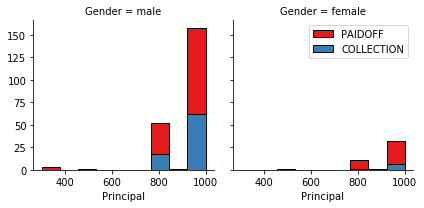

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

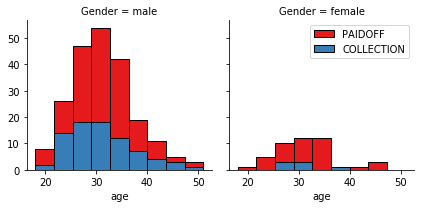

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

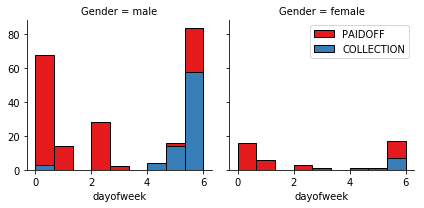

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


In [12]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

### Upsampling  
I noticed that the classes in the train set is not balanced. There are tendencies that the models over predict one class (in this cases PAIDOFF). Therefore, I decided to balance the classes, therefore upsampling the class (COLLECTION) which was lower.

In [13]:
from sklearn.utils import resample
Paidoff = df[df.loan_status == 'PAIDOFF']
Collected = df[df.loan_status == 'COLLECTION']

In [14]:
df_collection_upsampled = resample(Collected,
                       replace = True,
                       n_samples = len(Paidoff),
                       random_state = 42)

In [15]:
df_upsampled = pd.concat([Paidoff, df_collection_upsampled])

df_upsampled.head()
df_upsampled.shape

(520, 12)

In [16]:
print("Distinct counts before resampling \n", df.loan_status.value_counts())
print("#"*40)
print("Distinct counts before resampling \n", df_upsampled.loan_status.value_counts())

Distinct counts before resampling 
 PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64
########################################
Distinct counts before resampling 
 PAIDOFF       260
COLLECTION    260
Name: loan_status, dtype: int64


## Convert Categorical features to numerical values

Lets look at gender:

In [17]:
df_upsampled.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.725806
        COLLECTION     0.274194
male    COLLECTION     0.530568
        PAIDOFF        0.469432
Name: loan_status, dtype: float64

73 % of female pay their loans while only 50 % of males pay their loan


Lets convert male to 0 and female to 1:


In [18]:
df_upsampled['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df_upsampled.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [19]:
df_upsampled.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.515625
                      COLLECTION     0.484375
High School or Below  COLLECTION     0.506608
                      PAIDOFF        0.493392
Master or Above       COLLECTION     0.666667
                      PAIDOFF        0.333333
college               PAIDOFF        0.504425
                      COLLECTION     0.495575
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [20]:
df_upsampled[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [21]:
Feature = df_upsampled[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df_upsampled['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [22]:
X = Feature
X[0:5]
X.shape

(520, 8)

What are our lables?

In [23]:
y = df_upsampled['loan_status'].values
y[0:5]
y.shape

(520,)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [24]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.50863971,  0.84815844,  2.51951525, -0.36792823, -1.61589329,
        -0.37463432,  1.13611131, -0.87675965],
       [ 0.50863971,  0.84815844,  0.46222983,  2.71792141, -1.61589329,
         2.66926956, -0.88019545, -0.87675965],
       [ 0.50863971, -1.0822868 , -0.56641288, -0.36792823, -1.61589329,
        -0.37463432, -0.88019545,  1.14056344],
       [ 0.50863971,  0.84815844, -0.39497242,  2.71792141,  0.61885275,
        -0.37463432, -0.88019545,  1.14056344],
       [ 0.50863971,  0.84815844, -0.22353197, -0.36792823,  0.61885275,
        -0.37463432, -0.88019545,  1.14056344]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [75]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((390, 8), (390,), (130, 8), (130,))

In [26]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.78461538, 0.76923077, 0.75384615, 0.73846154, 0.69230769,
       0.73076923, 0.72307692, 0.76153846, 0.76923077])

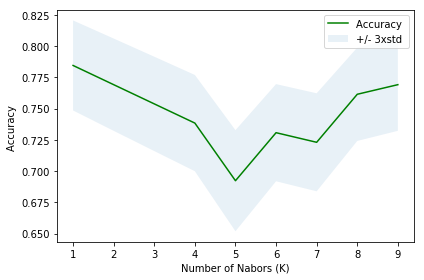

In [27]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [28]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7846153846153846 with k= 1


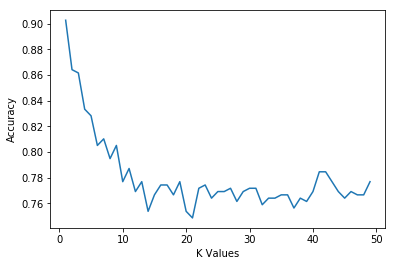

In [29]:

# Find Best K Value
score_list = []
for each in range(1,50):
    knn_2 = KNeighborsClassifier(n_neighbors = each)
    knn_2.fit(X_train, y_train)
    score_list.append(knn_2.score(X_train,y_train))

plt.plot(range(1,50), score_list)
plt.xlabel("K Values")
plt.ylabel("Accuracy")
plt.show()

This plot agrees with the plot above that the best number of neighbours is 1. We proceed to build the KNN model

In [30]:
k = 1
#Train Model  
knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

# Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint

dt_clf = DecisionTreeClassifier(random_state=42)

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'min_samples_split': sp_randint(2, 11), 
              'min_samples_leaf': sp_randint(1, 11)}

In [32]:
# Building the model using hyper parameter tuning

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

rand_dt = RandomizedSearchCV(dt_clf, param_grid, cv=10, scoring="accuracy", n_iter=100, random_state=42)
dec = rand_dt.fit(X_train,y_train)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Support Vector Machine

In [33]:
from sklearn.svm import SVC

sv_clf = SVC(random_state=42)

param_grid = [
              {'C': [1, 10, 100, 1000], 
               'kernel': ['linear']
              },
              {'C': [1, 10, 100, 1000], 
               'gamma': [0.001, 0.0001], 
               'kernel': ['rbf']
              },
 ]

In [34]:
# Building the SVM model using hyper parameter tuning

grid_sv = GridSearchCV(sv_clf, param_grid, cv=10, scoring="accuracy")
svm = grid_sv.fit(X_train,y_train)

# Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# Model Evaluation using Test set

In [36]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [37]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-02-18 12:14:58--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-02-18 12:14:59 (406 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [38]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [39]:
test_df.shape

(54, 10)

## Preprocessing the test set  
We need to pre process the test set just like the training set. We will use this test set to make predictions for the model built above

In [40]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [41]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

### Upsampling  
Just like the train set, I noticed that the classes in the test set is not balanced. There are tendencies that the models over predict one class (in this cases PAIDOFF). Therefore, I decided to balance the classes, therefore upsampling the class (COLLECTION) which was lower.

In [42]:
from sklearn.utils import resample
test_Paidoff = test_df[test_df.loan_status == 'PAIDOFF']
test_Collected = test_df[test_df.loan_status == 'COLLECTION']

In [43]:
test_df_collection_upsampled = resample(test_Collected,
                       replace = True,
                       n_samples = len(test_Paidoff),
                       random_state = 42)

In [44]:
test_df_upsampled = pd.concat([test_Paidoff, test_df_collection_upsampled])

test_df_upsampled.head()
test_df_upsampled.shape

(80, 12)

In [45]:
print("Distinct counts before resampling \n", test_df.loan_status.value_counts())
print("#"*40)
print("Distinct counts before resampling \n", test_df_upsampled.loan_status.value_counts())

Distinct counts before resampling 
 PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64
########################################
Distinct counts before resampling 
 PAIDOFF       40
COLLECTION    40
Name: loan_status, dtype: int64


In [46]:
test_df_upsampled['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df_upsampled.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [47]:
Feature1 = test_df_upsampled[['Principal','terms','age','Gender','weekend']]
Feature1 = pd.concat([Feature1,pd.get_dummies(test_df_upsampled['education'])], axis=1)
Feature1.drop(['Master or Above'], axis = 1,inplace=True)
Feature1.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [48]:
### Feature selection

# Defining the feature set for the test set

X_test = Feature1
X_test[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [49]:
# What are our lables?

y_test = test_df_upsampled['loan_status'].values
y_test.shape

(80,)

In [50]:
## Normalize Data 

# Data Standardization give data zero mean and unit variance (technically should be done after train test split )

X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_test.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


(80, 8)

The test set is now ready for evaluation for the models built. This also shows that the shape of the y_test and X_test are the same which makes it fit for evaluation.

## Evaluation for KNN

In [51]:
# Importing libraries
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score

In [52]:
knn_pred = knn.predict(X_test)

In [53]:
round(f1_score(y_test, knn_pred, average='weighted') ,2)

0.66

In [54]:
round(jaccard_similarity_score(y_test, knn_pred),2)

0.66

## Evaluation for Decision Tree

In [55]:
# Decision Tree Prediction
dec_pred = dec.predict(X_test)

In [56]:
round(f1_score(y_test, dec_pred, average='weighted'),2)

0.64

In [57]:
round(jaccard_similarity_score(y_test, dec_pred),2)

0.64

## Evaluation for SVM

In [58]:
## SVM Prediction
svm_pred = svm.predict(X_test)

In [59]:
round(f1_score(y_test, svm_pred, average='weighted'), 2)

0.72

In [60]:
round(jaccard_similarity_score(y_test, svm_pred), 2)

0.74

## Evaluation for Logistic Regression

In [61]:
# Logistic Regression Prediction
LR_pred = LR.predict(X_test)

In [62]:
# Getting the probabilites in order to calculate the log loss
LR_pred_prob = LR.predict_proba(X_test)
LR_pred_prob[0:5]

array([[0.18112648, 0.81887352],
       [0.475657  , 0.524343  ],
       [0.5251552 , 0.4748448 ],
       [0.64121276, 0.35878724],
       [0.53573198, 0.46426802]])

In [63]:
round(f1_score(y_test, LR_pred, average='weighted') ,2)

0.77

In [64]:
round(jaccard_similarity_score(y_test, LR_pred),2)

0.78

In [65]:
round(log_loss(y_test, LR_pred_prob), 2)

0.56

## Confusion Matrix For the Models

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### For KNN

Confusion matrix, without normalization
[[28 12]
 [15 25]]


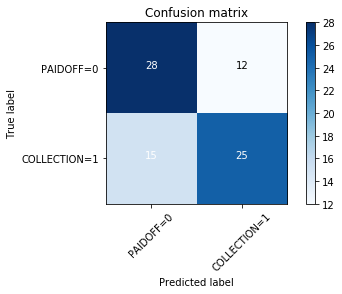

In [67]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, knn_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF=0','COLLECTION=1'],normalize= False,  title='Confusion matrix')

In [68]:
print (classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

  COLLECTION       0.68      0.62      0.65        40
     PAIDOFF       0.65      0.70      0.67        40

   micro avg       0.66      0.66      0.66        80
   macro avg       0.66      0.66      0.66        80
weighted avg       0.66      0.66      0.66        80



### For Decision Tree

Confusion matrix, without normalization
[[28 12]
 [17 23]]


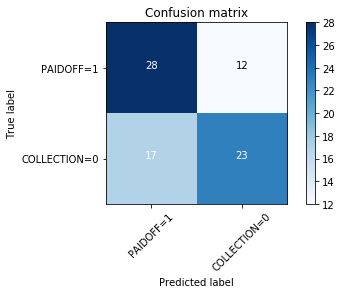

In [69]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, dec_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF=1','COLLECTION=0'],normalize= False,  title='Confusion matrix')

In [70]:
print (classification_report(y_test, dec_pred))

              precision    recall  f1-score   support

  COLLECTION       0.66      0.57      0.61        40
     PAIDOFF       0.62      0.70      0.66        40

   micro avg       0.64      0.64      0.64        80
   macro avg       0.64      0.64      0.64        80
weighted avg       0.64      0.64      0.64        80



### For Support Vector Machine

Confusion matrix, without normalization
[[20 20]
 [ 1 39]]


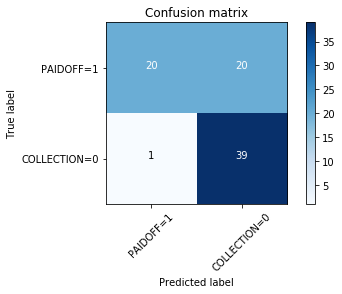

In [71]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, svm_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF=1','COLLECTION=0'],normalize= False,  title='Confusion matrix')

In [72]:
print (classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

  COLLECTION       0.66      0.97      0.79        40
     PAIDOFF       0.95      0.50      0.66        40

   micro avg       0.74      0.74      0.74        80
   macro avg       0.81      0.74      0.72        80
weighted avg       0.81      0.74      0.72        80



### For Logistic Regression

Confusion matrix, without normalization
[[23 17]
 [ 1 39]]


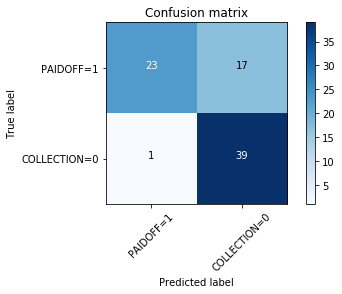

In [73]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, LR_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF=1','COLLECTION=0'],normalize= False,  title='Confusion matrix')

In [74]:
print (classification_report(y_test, LR_pred))

              precision    recall  f1-score   support

  COLLECTION       0.70      0.97      0.81        40
     PAIDOFF       0.96      0.57      0.72        40

   micro avg       0.78      0.78      0.78        80
   macro avg       0.83      0.77      0.77        80
weighted avg       0.83      0.78      0.77        80



# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.66    | 0.66     | NA      |
| Decision Tree      | 0.64    | 0.64     | NA      |
| SVM                | 0.74    | 0.72     | NA      |
| LogisticRegression | 0.78    | 0.77     | 0.56    |

I noticed that the results fairly imporoved when I resampled the classes, thereby producing a more realistic evaluation of the classes. In fact, the confusion matrix was able to predict the classes well.   
From the above, the **Logistic Regression** was the best model for the data based on the metrics used.

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>